In [1]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
yf.pdr_override()
from datetime import datetime
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import data_util

In [2]:
# apple_stocks=data_util.stock_data('AAPL',4,'Apple')
n_stocks=data_util.stock_data('^NSEI', 4,'Nifty 50')
# plot(apple_stocks,'Apple')  

[*********************100%%**********************]  1 of 1 completed


In [3]:
stocks = n_stocks[['Close']].copy()

### We First do the Augmented Dickey Fuller Test to check the Stationarity of the Data


In [4]:
test_Results=adfuller(stocks["Close"])
print("p-value of the Test",test_Results[1])

p-value of the Test 0.2712753932154557


#### Since the p-value is large , we conclude that the data is not stationary. We take the difference and again do the ADS test .

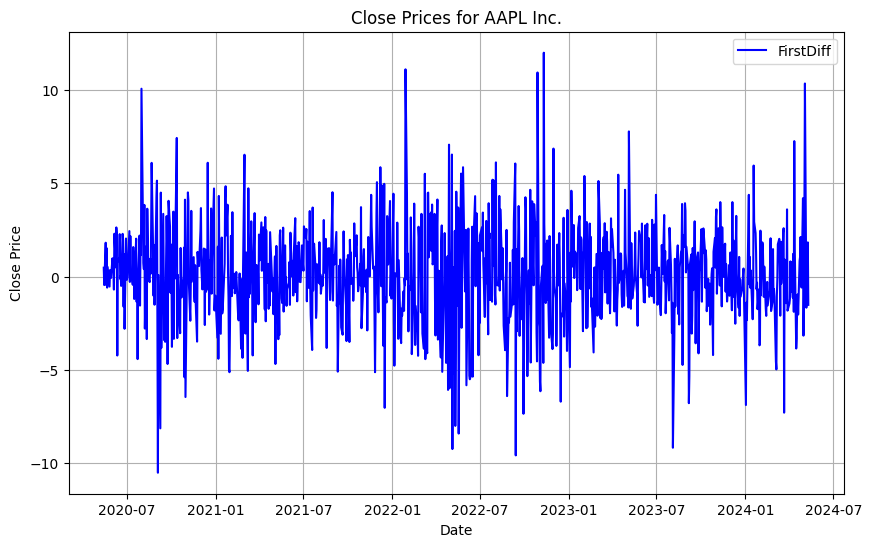

In [33]:
stocks['FirstDiff'] = stocks['Close'].diff().dropna()
plt.figure(figsize=(10, 6))
plt.plot(stocks.index, stocks['FirstDiff'], color='blue', label='FirstDiff')
plt.title(f'Close Prices for {"AAPL"} Inc.')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()  
plt.grid(True)
plt.show()

In [34]:
test_Results=adfuller(stocks["FirstDiff"][1:])#first entry will be Nan
print("p-value of the Test",test_Results[1])

p-value of the Test 0.0


#### On taking the first difference we get the p-value as low as 0.00 , thus we conclude the first diffeernce data is stationary . This can be further be confirmed by using ndiff function in pmdarima library.

In [231]:
from pmdarima.arima.utils import ndiffs

d = ndiffs(stocks["Close"])

print("No. of differences needed:", d)

No. of differences needed: 1


#### Now we plot AutoCorrelation Function(ACF) and Partial AutoCorrelation Function(PACF) to determing the order of ARIMA model.

<BarContainer object of 30 artists>

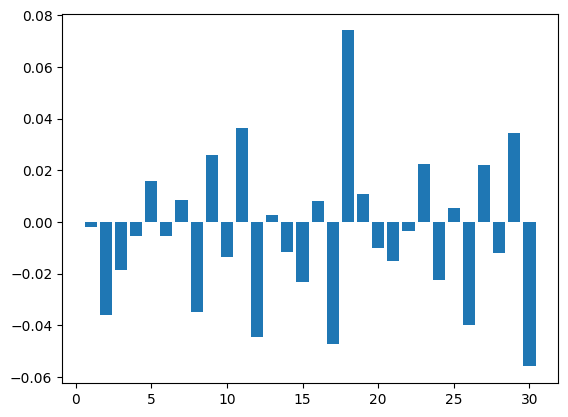

In [232]:
acf_vals = acf(stocks['FirstDiff'][1:])
plt.bar(range(1,acf_vals.shape[0]), acf_vals[1:acf_vals.shape[0]])
# acf_vals.shape

<BarContainer object of 30 artists>

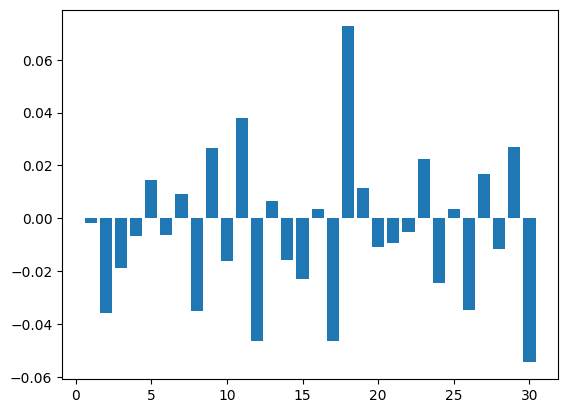

In [233]:
pacf_vals = pacf(stocks['FirstDiff'][1:])
plt.bar(range(1,pacf_vals.shape[0]), pacf_vals[1:pacf_vals.shape[0]])

In [234]:
train=pd.DataFrame(stocks['Close'][0:int(len(stocks)*0.70)])
test=pd.DataFrame(stocks['Close'][int(len(stocks)*0.70):])


In [235]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(train, order=(2,1,2))
# model = ARIMA(stocks['FirstDiff'][1:], order=(2,0,2))

model_fit = model.fit()
print(model_fit.summary())

c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  705
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1719.894
Date:                Sat, 11 May 2024   AIC                           3449.788
Time:                        23:32:24   BIC                           3472.572
Sample:                             0   HQIC                          3458.593
                                - 705                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9792      0.007    135.211      0.000       0.965       0.993
ar.L2         -0.9984      0.007   -148.392      0.000      -1.012      -0.985
ma.L1         -0.9840      0.013    -77.181      0.0

c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(array([0.00371983, 0.00495977, 0.03719831, 0.07501658, 0.17297212,
        0.09857551, 0.03533839, 0.00619972, 0.00061997, 0.00185992]),
 array([-10.30551867,  -8.01435859,  -5.72319851,  -3.43203843,
         -1.14087835,   1.15028173,   3.4414418 ,   5.73260188,
          8.02376196,  10.31492204,  12.60608212]),
 <BarContainer object of 10 artists>)

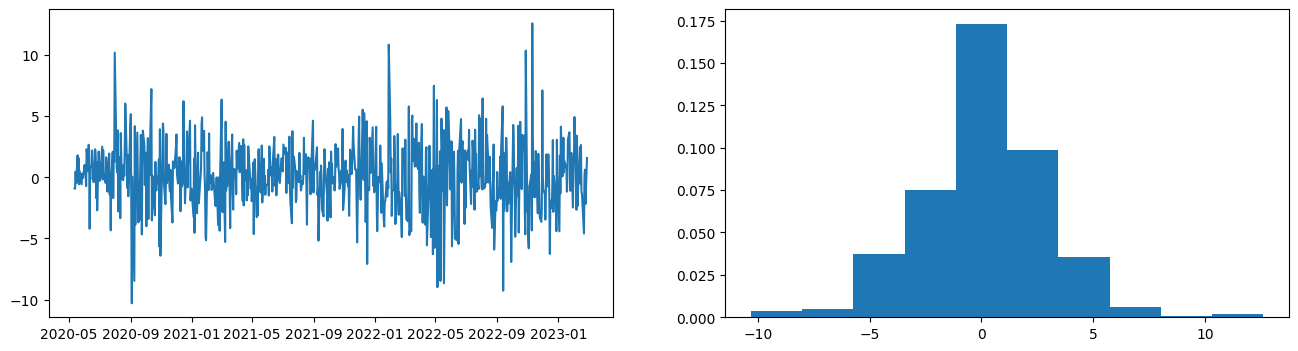

In [236]:
residuals = pd.DataFrame(model_fit.resid[1:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)

ax2.hist(residuals, density=True)

In [276]:
predictions = model_fit.forecast(len(test))

dates = test.index.tolist()  # Convert index to list of dates
predictions = predictions.tolist()  # Convert predicted values to list

# Create a DataFrame using the lists of dates and predictions
predicted_df = pd.DataFrame({'Predicted_Value': predictions}, index=dates)

# Print the DataFrame
print(predicted_df)



            Predicted_Value
2023-02-28       148.083426
2023-03-01       148.604581
2023-03-02       148.951710
2023-03-03       148.771285
2023-03-06       148.248047
...                     ...
2024-05-06       148.673815
2024-05-07       148.846943
2024-05-08       148.599578
2024-05-09       148.184517
2024-05-10       148.025074

[303 rows x 1 columns]


c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


705    148.083426
dtype: float64

In [277]:
test.index

DatetimeIndex(['2023-02-28', '2023-03-01', '2023-03-02', '2023-03-03',
               '2023-03-06', '2023-03-07', '2023-03-08', '2023-03-09',
               '2023-03-10', '2023-03-13',
               ...
               '2024-04-29', '2024-04-30', '2024-05-01', '2024-05-02',
               '2024-05-03', '2024-05-06', '2024-05-07', '2024-05-08',
               '2024-05-09', '2024-05-10'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)

In [278]:
predicted_df.index

DatetimeIndex(['2023-02-28', '2023-03-01', '2023-03-02', '2023-03-03',
               '2023-03-06', '2023-03-07', '2023-03-08', '2023-03-09',
               '2023-03-10', '2023-03-13',
               ...
               '2024-04-29', '2024-04-30', '2024-05-01', '2024-05-02',
               '2024-05-03', '2024-05-06', '2024-05-07', '2024-05-08',
               '2024-05-09', '2024-05-10'],
              dtype='datetime64[ns]', length=303, freq=None)

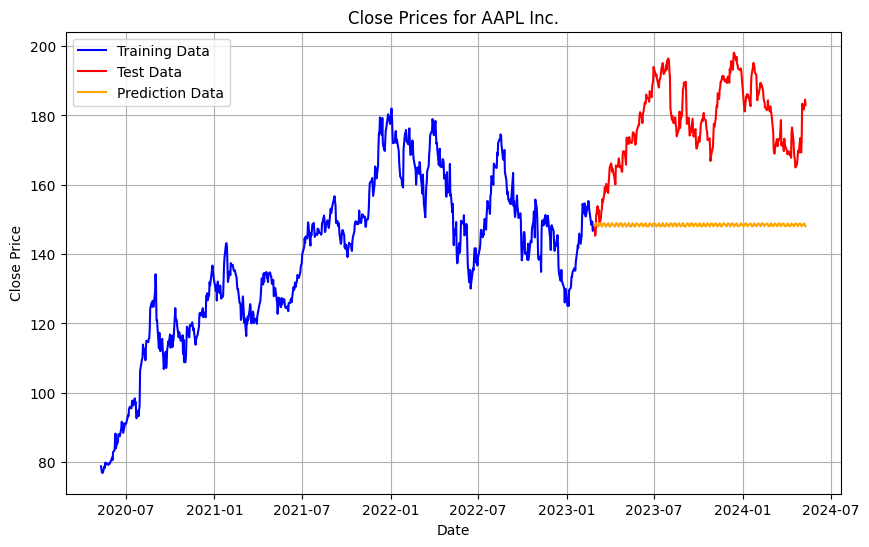

In [279]:
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(train.index, train, color='blue', label='Training Data')

# Plot test data
plt.plot(test.index, test, color='red', label='Test Data')
plt.plot(predicted_df.index, predicted_df, color='orange', label='Prediction Data')

plt.title('Close Prices for AAPL Inc.')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [301]:
test['Close'][0]

147.41000366210938

In [308]:
test.shape

(303, 1)

: 

## Rolling Forecast Origin

In [303]:
import warnings
warnings.filterwarnings("ignore")
rolling=int(len(stocks)*0.70)
train=pd.DataFrame(stocks['Close'][0:rolling])
test=pd.DataFrame(stocks['Close'][rolling:])
predictions_rolling=[]
for i in range(len(test)):

    model = ARIMA(train, order=(2,1,2))
    model_fit = model.fit()
    pred=model_fit.forecast()
    predictions_rolling.append(pred)
    print(float(pred),test['Close'][i])
    rolling+=1
    train=pd.DataFrame(stocks['Close'][0:rolling])
print(predictions_rolling)

148.08342554326552 147.41000366210938
147.91051285884765 145.30999755859375
145.6627721423375 145.91000366210938
145.7729007740799 151.02999877929688
150.5473698469436 153.8300018310547
153.44939921969782 151.60000610351562
151.7238404105354 152.8699951171875
153.3506858815735 150.58999633789062
150.99989788097974 148.5
148.43789578474522 150.47000122070312
150.21001004725298 152.58999633789062
152.30669567618017 152.99000549316406
152.59860567549524 155.85000610351562
155.62885797148442 155.0
155.02958338363499 157.39999389648438
157.3508617193464 159.27999877929688
158.9736641300787 157.8300018310547
157.45968448612365 158.92999267578125
159.0170984629944 160.25
160.67157945999097 158.27999877929688
158.32299419173168 157.64999389648438
157.80952021057925 160.77000427246094
160.63456218974048 162.36000061035156
162.07870316060556 164.89999389648438
164.59211512724067 166.1699981689453
165.9301528635651 165.6300048828125
165.6219738000093 163.75999450683594
163.98546916712004 164.6600

In [304]:
predictions_rolling=[float(i) for i in predictions_rolling]

In [305]:

dates = test.index.tolist()

rolling_predicted_df = pd.DataFrame({'Predicted_Value': predictions_rolling}, index=dates)

# Print the DataFrame
print(rolling_predicted_df)


            Predicted_Value
2023-02-28       148.083426
2023-03-01       147.910513
2023-03-02       145.662772
2023-03-03       145.772901
2023-03-06       150.547370
...                     ...
2024-05-06       183.337260
2024-05-07       181.276337
2024-05-08       182.620301
2024-05-09       182.831809
2024-05-10       184.732854

[303 rows x 1 columns]


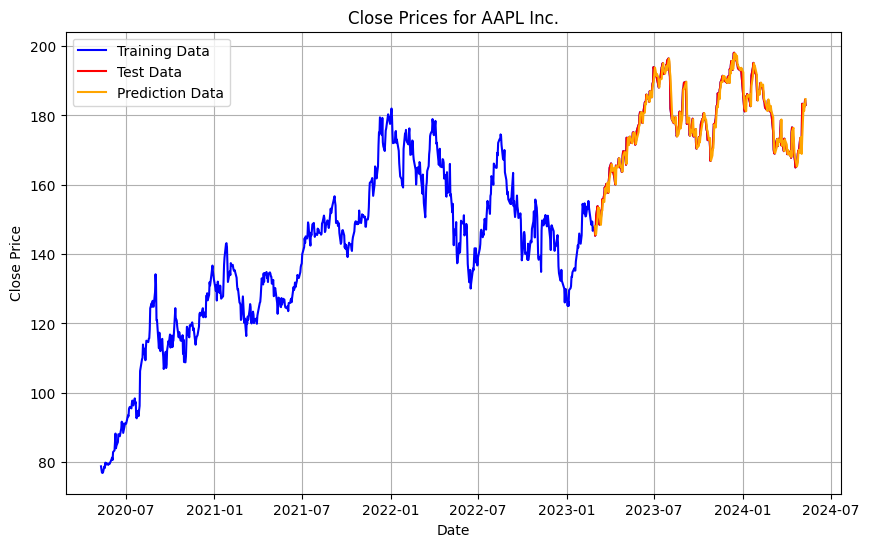

In [306]:
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(train.index, train, color='blue', label='Training Data')

# Plot test data
plt.plot(test.index, test, color='red', label='Test Data')
plt.plot(rolling_predicted_df.index, rolling_predicted_df, color='orange', label='Prediction Data')

plt.title('Close Prices for AAPL Inc.')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()
